In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression

In [2]:
# Import original first just to get back the listing description features:

mar19 = pd.read_csv("/Users/bridmcnulty/Desktop/listings.csv", low_memory=False)
feb19 = pd.read_csv("/Users/bridmcnulty/Desktop/feb2.csv", low_memory=False)

In [3]:
# Joining March 19 and Feb 19 data together and dropping listing duplicates - so we're left with a little bit more listings than just one month's worth (I suppose some went inactive? New listings added?)
frames = [mar19, feb19]

data_mf = pd.concat(frames)
# 157544 rows, 106 cols

# Drop duplicates, keep first only
data_mf.drop_duplicates(subset ="id", 
                     keep = 'first', inplace = True) 

In [4]:
data_mf.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20190307140352,2019-03-08,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,3,1,2,0,0.13
1,15400,https://www.airbnb.com/rooms/15400,20190307140352,2019-03-08,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.72


In [5]:
listings_qual_description = ['name','summary','space','description','neighborhood_overview','notes',
'transit','access','interaction','house_rules','id']

test = data_mf[listings_qual_description]

In [6]:
test.isnull().sum()

name                        27
summary                   3623
space                    26279
description               1620
neighborhood_overview    32071
notes                    51193
transit                  32010
access                   36429
interaction              36507
house_rules              34897
id                           0
dtype: int64

In [7]:
# Summary and description are only two descriptive fields with relatively few nulls:
descriptive = data_mf[['id','summary','description']]
descriptive.dropna(inplace=True)

/Users/bridmcnulty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Bring in cleaned_data that has nulls removed and income_class included:
df = pd.read_csv("/Users/bridmcnulty/Desktop/cleaned_data.csv", low_memory=False)
df.drop(columns='Unnamed: 0',inplace=True)

In [9]:
# Merge onto df the listing description cols from data_mf

df = df.merge(right=descriptive,on='id')
df.head(1)

,id,experiences_offered,host_id,host_name,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,...,vader_neu_summary,vader_compound_summary,vader_neg_summary,vader_pos_summary,vader_compound_desc,vader_pos_desc,vader_neg_desc,vader_neu_desc,summary,description
0,13913,business,54730,Alina,within a day,60.0,0,4.0,"['email', 'phone', 'facebook', 'reviews']",1,...,0.582,0.9747,0.028,0.39,0.9949,0.284,0.009,0.707,My bright double bedroom with a large window h...,My bright double bedroom with a large window h...


In [10]:
# Sentiment Analysis For Summary Feature

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
for summary in df.summary.values[0:2]:
    vs = analyzer.polarity_scores(summary)
    print(summary)
    print(vs)

My bright double bedroom with a large window has a relaxed feeling! It comfortably fits one or two and is centrally located just two blocks from Finsbury Park. Enjoy great restaurants in the area and easy access to easy transport tubes, trains and buses. Babies and children of all ages are welcome.
{'neg': 0.028, 'neu': 0.582, 'pos': 0.39, 'compound': 0.9747}
Lots of windows and light.  St Luke's Gardens are at the end of the block, and the river not too far the other way. Ten minutes walk if you go slowly. Buses to everywhere round the corner and shops, restaurants, pubs, the cinema and Waitrose .
{'neg': 0.062, 'neu': 0.938, 'pos': 0.0, 'compound': -0.4404}


In [11]:
vader_scores = df['summary'].map(analyzer.polarity_scores)

from sklearn.feature_extraction import DictVectorizer
dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores)
vader_scores

<44105x4 sparse matrix of type '<class 'numpy.float64'>'
	with 134884 stored elements in Compressed Sparse Row format>

In [12]:
for i, col in enumerate(dvec.feature_names_):
    df['vader_{}_summary'.format(col)] = vader_scores[:, i].toarray().ravel()

In [13]:
# Sentiment Analysis for Descriptions

vader_scores = df['description'].map(analyzer.polarity_scores)

from sklearn.feature_extraction import DictVectorizer
dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores)

for i, col in enumerate(dvec.feature_names_):
    df['vader_{}_desc'.format(col)] = vader_scores[:, i].toarray().ravel()

In [28]:
cols = df[['host_is_superhost',
                    'neighbourhood_cleansed','tube_proximity',
                    'host_response_rate','host_since_ago',
                    'host_listings_count','room_type','host_identity_verified',
                    'longitude','accommodates','bathrooms','bedrooms','beds',
                    'extra_people','availability_30','availability_60',
                    'availability_90','availability_365','number_of_reviews','review_scores_accuracy',
                    'review_scores_cleanliness',
                     'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
                    'first_review_days_ago','experiences_offered','vader_neu_summary',
          'vader_compound_desc','vader_pos_desc','vader_neg_desc','vader_neg_summary','vader_pos_summary']]
#'price','capped_or',,'minimum_nights','cleaning_fee',

y = df.capped_or_income
X = pd.get_dummies(cols,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test, y_test)

/Users/bridmcnulty/anaconda3/envs/textacy/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bridmcnulty/anaconda3/envs/textacy/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/bridmcnulty/anaconda3/envs/textacy/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


0.3997525418006397

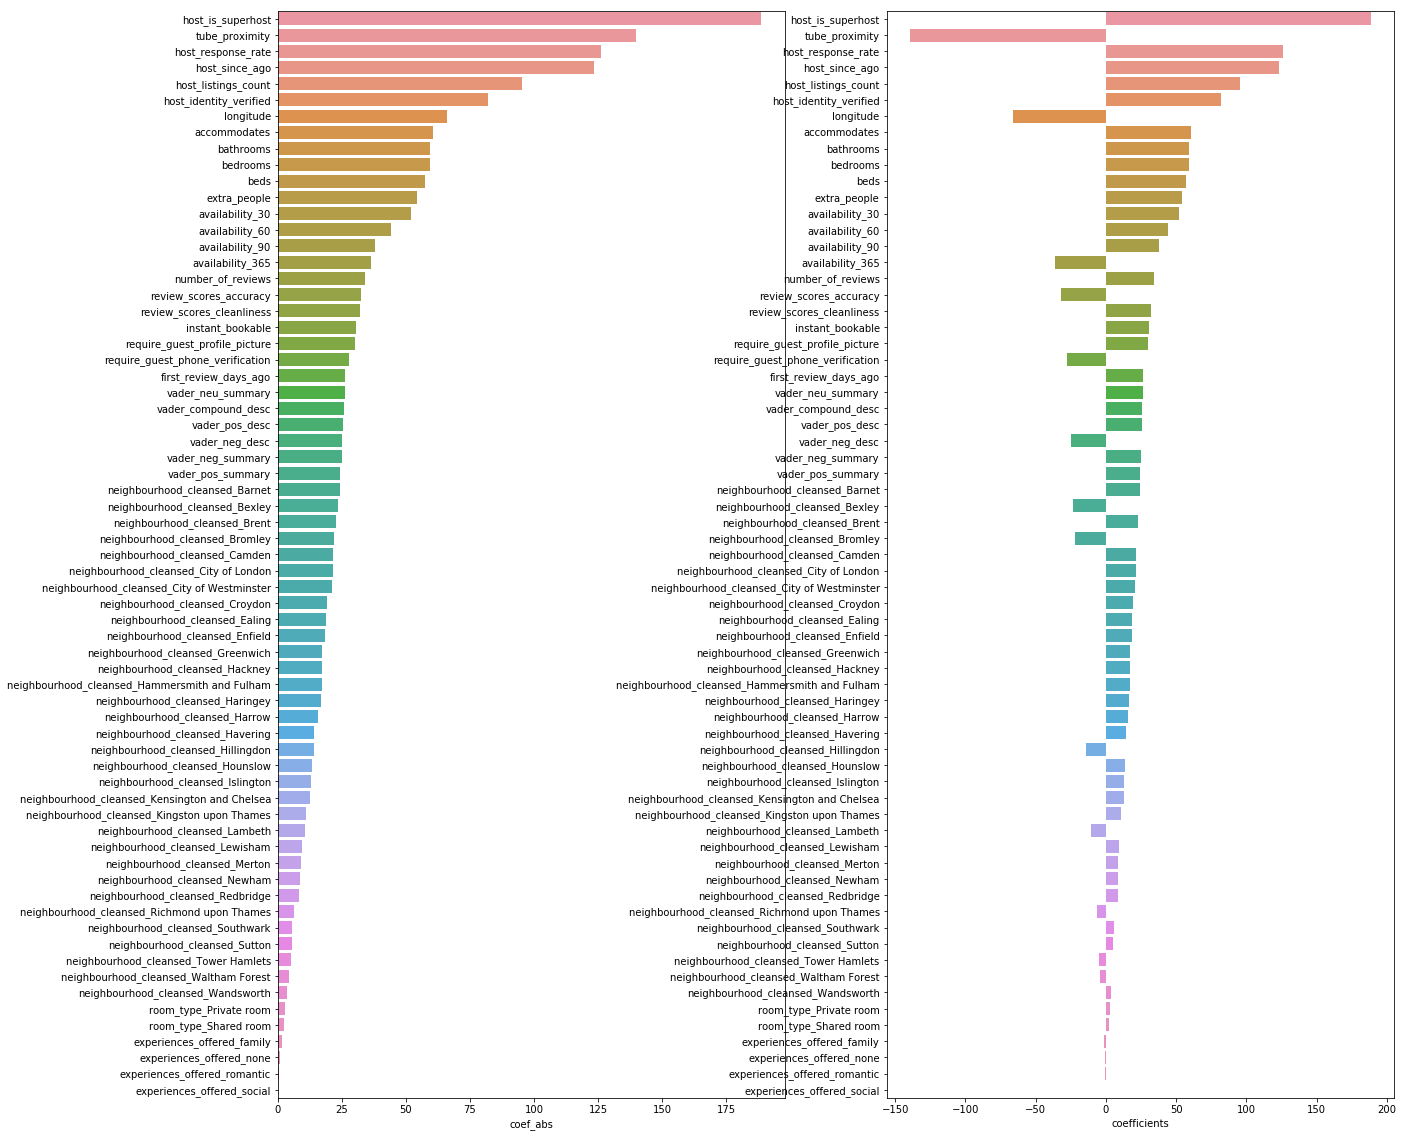

In [29]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lr.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef = df_coef.sort_values('coef_abs', ascending=False)

# plot the magnitude of the coefficients
fix, ax = plt.subplots(ncols=2,figsize=(20,20))#,sharey=True)
sns.barplot(df_coef.coef_abs,X_train.columns,ax=ax[0])
sns.barplot(df_coef.coefficients,X_train.columns,ax=ax[1])
plt.show()

In [20]:
print('--- Compound Score ---')
print(df.vader_compound_desc.corr(df.capped_or_income))
print(df.vader_compound_summary.corr(df.capped_or_income))
print('--- Pos Score ---')
print(df.vader_pos_desc.corr(df.capped_or_income))
print(df.vader_pos_summary.corr(df.capped_or_income))
print('--- Neg Score ---')
print(df.vader_neg_desc.corr(df.capped_or_income))
print(df.vader_neg_summary.corr(df.capped_or_income))

# Very slight correlation: More positive your summary and description => More income.

--- Compound Score ---
0.031210552639912775
0.05040467321037171
--- Pos Score ---
0.006434722622162949
0.011921805526095666
--- Neg Score ---
-0.020759997976437967
-0.005124596911432627


# Buzzwords Used In Summaries For Income Classes

In [14]:
income_classes = pd.read_csv("/Users/bridmcnulty/Desktop/id_and_income_class_imbalanced.csv")
income_classes.drop(columns=['Unnamed: 0'],inplace=True)
income_classes.head(2)

,id,income_class
0,13913,D
1,15400,C


In [15]:
df = df.merge(income_classes, how='left',on='id')
df.head(2)

,id,experiences_offered,host_id,host_name,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,...,vader_compound_summary,vader_neg_summary,vader_pos_summary,vader_compound_desc,vader_pos_desc,vader_neg_desc,vader_neu_desc,summary,description,income_class
0,13913,business,54730,Alina,within a day,60.0,0,4.0,"['email', 'phone', 'facebook', 'reviews']",1,...,0.9747,0.028,0.39,0.9949,0.284,0.009,0.707,My bright double bedroom with a large window h...,My bright double bedroom with a large window h...,D
1,15400,romantic,60302,Philippa,within a few hours,100.0,0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,...,-0.4404,0.062,0.00,0.9586,0.120,0.016,0.864,Lots of windows and light. St Luke's Gardens ...,Lots of windows and light. St Luke's Gardens ...,C


In [16]:
# Subset each income class to do word clouds on:

A = df[df['income_class']=='A']
B = df[df['income_class']=='B']
C = df[df['income_class']=='C']
D = df[df['income_class']=='D']

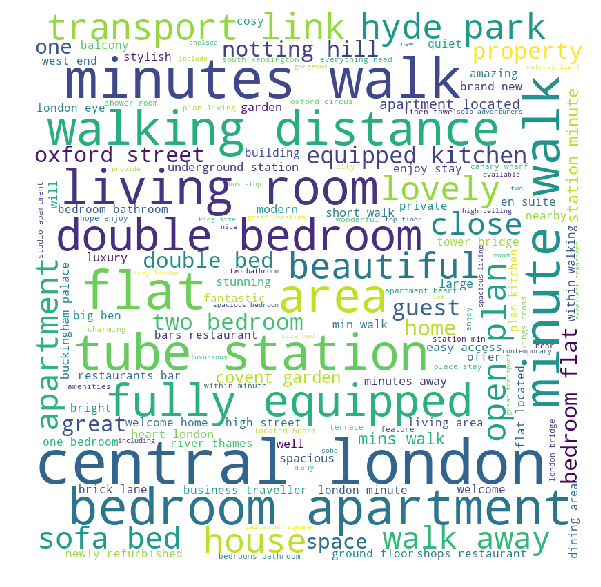

In [17]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in A.summary: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

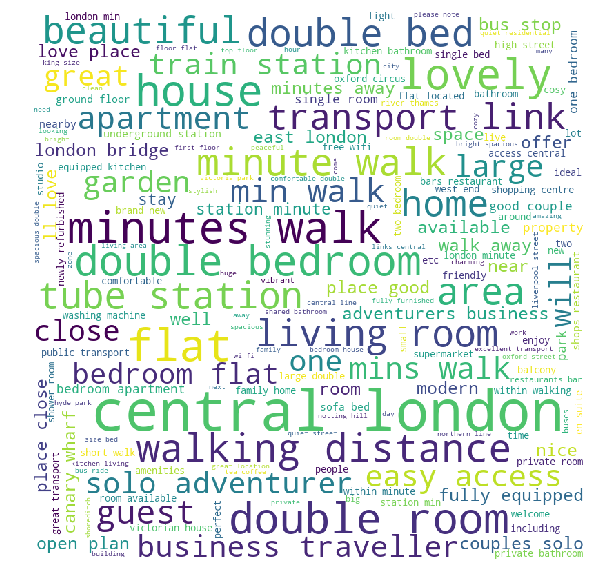

In [18]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in D.summary: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# Save Id and Vader Scores To Be Imported Elsewhere

In [ ]:
df.neighbourhood_cleansed

In [33]:
export = df[['vader_neu_summary','vader_compound_summary','vader_neg_summary','vader_pos_summary',
    'vader_compound_desc','vader_pos_desc','vader_neg_desc','vader_neu_desc','id']]
export.to_csv("/Users/bridmcnulty/Desktop/desc_vader.csv")